In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim.downloader as gensim_downloader
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import _pickle as pickle
import seaborn as sns
import tensorflow as tf


In [40]:
df = pd.read_csv("data/covid19_articles_20201231_reduced.csv")

WE_BIGRAM_PHRASER_FILEPATH = "we_bigram_phraser.pkl"
bigram_phraser = pickle.load(open(WE_BIGRAM_PHRASER_FILEPATH, "rb"))

nlp = gensim_downloader.load("word2vec-google-news-300")


In [41]:
def stratified_sample_df(df, col, n_samples, random_state=69, save=False):
    n = min(n_samples, df[col].value_counts().min())
    df_ = df.groupby(col).apply(lambda x: x.sample(n, random_state=random_state))
    df_.index = df_.index.droplevel(0)
    if save:
        df_.to_csv("processed_data/tfidf_df_random.csv")
    return df_


df = stratified_sample_df(df, "topic_area", 1250)


In [42]:
## Tokenizer taken from TensorFLow
## https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer()


In [43]:
MAX_LENGTH = 150
_ = []
for sen in df["content"]:
    w = sen.split()
    _.append(w)
## get bigrams
_ = list(bigram_phraser[_])
## fit tokenizer
tokenizer.fit_on_texts(_)
## create sequences
seqences = tokenizer.texts_to_sequences(_)

X = tf.keras.preprocessing.sequence.pad_sequences(
    seqences, maxlen=MAX_LENGTH, padding="post", truncating="post"
)

y = df.iloc[:, -1]

y_map = {a: b for a, b in enumerate(np.unique(y))}
y_map_reverse = {b: a for a, b in y_map.items()}
y = np.array([y_map_reverse[a] for a in y])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=69
)


In [44]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(7000, 150)
(7000,)
(1750, 150)
(1750,)


In [45]:
model = XGBClassifier(
    objective="multi:softmax",
    num_class=len(np.unique(y_train)),
    colsample_bytree=0.2,
    subsample=0.7,
    random_state=69,
    max_depth=4,
    eval_metric="merror",
    use_label_encoder=False,
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)


In [46]:
pickle.dump(model, open("saved_models/xgboost_we_model.pkl", "wb"))


In [47]:
accuracy = metrics.accuracy_score(y_test, y_pred)
roc = metrics.roc_auc_score(y_test, y_pred_prob, multi_class="ovr")
class_report = metrics.classification_report(y_test, y_pred)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)


# Visualisations

In [48]:
print(class_report)


              precision    recall  f1-score   support

           0       0.69      0.78      0.73       250
           1       0.81      0.73      0.77       250
           2       0.53      0.65      0.58       250
           3       0.68      0.61      0.65       250
           4       0.66      0.73      0.69       250
           5       0.87      0.80      0.83       250
           6       0.92      0.73      0.82       250

    accuracy                           0.72      1750
   macro avg       0.74      0.72      0.72      1750
weighted avg       0.74      0.72      0.72      1750



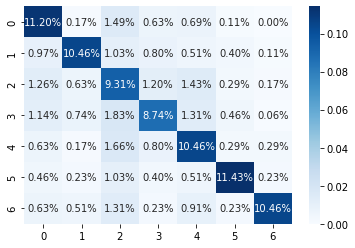

In [49]:
sns.heatmap(
    confusion_matrix / np.sum(confusion_matrix), fmt=".2%", annot=True, cmap="Blues"
)
plt.show()


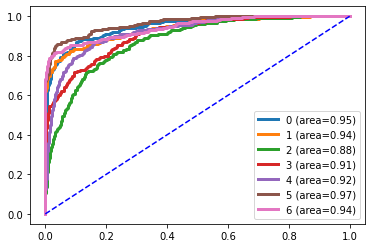

In [50]:
## https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
classes = [x for x in range(7)]
y_test_array = pd.get_dummies(y_test, drop_first=False).values
fig, ax = plt.subplots()
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:, i], y_pred_prob[:, i])
    ax.plot(
        fpr,
        tpr,
        lw=3,
        label="{0} (area={1:0.2f})".format(classes[i], metrics.auc(fpr, tpr)),
    )
ax.plot([0, 1], [0, 1], color="blue", linestyle="--")
ax.legend()


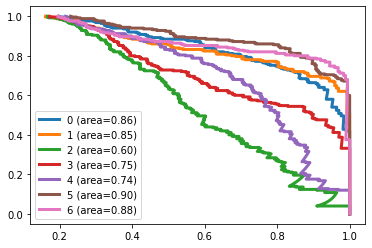

In [51]:
y_test_array = pd.get_dummies(y_test, drop_first=False).values
fig, ax = plt.subplots()
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
        y_test_array[:, i], y_pred_prob[:, i]
    )
    ax.plot(
        precision,
        recall,
        lw=3,
        label="{0} (area={1:0.2f})".format(classes[i], metrics.auc(recall, precision)),
    )
ax.legend()
